# Importing neceassary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from itertools import cycle
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle

from imblearn.over_sampling import SMOTE

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from keras.models import save_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l1, l2
from scikeras.wrappers import KerasClassifier

C:\Users\logoz\AppData\Local\Temp\ipykernel_50516\1582718787.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Standardization functions
def calculate_mean(data):
    return sum(data)/len(data)

def calculate_standard_deviation(data, mean):
    variance = sum((x - mean)**2 for x in data)/len(data)
    std_dev = sqrt(variance)
    return std_dev

# Standardization Function
def standardize(data):
    mean = calculate_mean(data)
    std_dev = calculate_standard_deviation(data, mean)
    print(f"Mean: {mean}, SD: {std_dev}")
    return (data - mean)/std_dev

# Creating the dataframe

In [3]:
def read_csv_create_train_test(test_split, features):
    """
    test_split (input): The percentage of data that will be used to test
    features (input): Can be 'all', 'anova' or 'extratrees'
    """
    # Specify the pattern for your csv files
    csv_files = glob.glob('*.csv')

    # List comprehension to load all csv files into DataFrames
    dataframes = [pd.read_csv(file) for file in csv_files]

    # Concatenate all DataFrames into one
    combined_dataframe = pd.concat(dataframes, ignore_index=True)

    # some columns are totally unproductive so let's remove them
    combined_dataframe.drop(['Sample Count'],axis=1,inplace=True)

    # Standardizing the dataframe
    for column in combined_dataframe.columns.drop(['Movement']):
        print(f"For feature {column}")
        combined_dataframe[column] = standardize(combined_dataframe[column])

    if features == 'all':
        # All features
        X = combined_dataframe.drop(['Movement'],axis=1)
    elif features == 'anova':
        # Features based on ANOVA F-Test
        features = ['Mean', 'Skewness', 'Kurtosis', 'Relative Theta Power', 'Relative Alpha Power', 'Relative Beta Power',
                    'Relative Gamma Power', 'Relative Mu Power', 'Entropy', 'Complexity', 'Bispectrum Relative Theta Power',
                    'Bispectrum Relative Alpha Power', 'Bispectrum Relative Beta Power', 'Bispectrum Relative Gamma Power', 'Third Moment']
        X = combined_dataframe[features]
        print(X.head())
    elif features == 'extratrees':
        # Feature based on ExtraTreesClassifier
        # features = ['Relative Theta Power', 'Bispectrum Relative Gamma Power', 'Bispectrum Relative Delta Power', 'Entropy', 'Relative Beta Power', 'Bispectrum Relative Mu Power', 'Bispectrum Relative Theta Power', 'Activity', 'Skewness', 'Zero Crossing Rate']
        features = ['Variance', 'Skewness', 'Kurtosis', 'Relative Beta Power', 'Relative Gamma Power', 'Entropy', 'Zero Crossing Rate', 'Complexity', 'Bispectrum Relative Beta Power', 'Bispectrum Relative Gamma Power']
        X = combined_dataframe[features]

    y = combined_dataframe.Movement

    # Convert labels to one-hot encoding
    y = to_categorical(y)  # Ensure this matches the classes correctly

    # # Splitting the dataset into the Training set and Test set. Stratify should keep all classes of movement balanced
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_split, random_state = 42, stratify=y)

    # Splitting the dataset into the Training set and Test set. Stratify should keep all classes of movement balanced
    X_use, X_val, y_use, y_val = train_test_split(X, y, test_size = test_split, random_state = 42, stratify=y)

    # Splitting the dataset into the Training set and Test set. Stratify should keep all classes of movement balanced
    X_train, X_test, y_train, y_test = train_test_split(X_use, y_use, test_size = test_split, random_state = 42, stratify=y_use)

    # # Apply SMOTE
    # smote = SMOTE(random_state=42)
    # X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # # Feature Scaling because we don't want one independent variable dominating the other and it makes computations easy
    # sc = StandardScaler()
    # X_train_smote = sc.fit_transform(X_train_smote)
    # X_test = sc.transform(X_test)

    # return combined_dataframe, X_train_smote, X_test, y_train_smote, y_test
    return combined_dataframe, X_train, X_test, X_val, y_train, y_test, y_val

# ANOVA F-Test

In [4]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif

# df, X_train, X_test, y_train, y_test = read_csv_create_train_test(test_split=0.2, features='all')

# # Separate features and target
# X = df.drop(['Movement'], axis=1)
# y = df.Movement

# # Store column names
# feature_names = X.columns

# cutoff = 0.3

# # # # Scale the features
# # # scaler = StandardScaler()
# # # X_scaled = scaler.fit_transform(X)

# # Apply ANOVA F-test
# anova_selector = SelectKBest(f_classif, k='all')  # Set k='all' to get scores for all features
# X_kbest = anova_selector.fit_transform(X, y)

# # Get the p-values for each feature
# p_values = anova_selector.pvalues_

# # Print the p-values
# for i, col in enumerate(X.columns):
#     print(f"{col}: ANOVA F-test p-value = {p_values[i]}")

# # List to store features with p-value > 0.2
# features_with_high_p_value = [col for i, col in enumerate(X.columns) if p_values[i] > cutoff]

# # Print the list of features with p-value > 0.2
# print(f"Features with p-value > {cutoff}:", features_with_high_p_value)

# plt.bar(feature_names, p_values, width=0.8, bottom=None, align='center')

# # ['Mean', 'Skewness', 'Kurtosis', 'Relative Theta Power', 'Relative Alpha Power', 'Relative Beta Power', 'Relative Gamma Power', 'Relative Mu Power', 'Entropy', 'Complexity', 'Bispectrum Relative Theta Power', 'Bispectrum Relative Alpha Power', 'Bispectrum Relative Beta Power', 'Bispectrum Relative Gamma Power', 'Third Moment']

# Extra Trees

In [5]:
# from sklearn.ensemble import ExtraTreesClassifier
# import matplotlib.pyplot as plt

# df, X_train, X_test, y_train, y_test = read_csv_create_train_test(test_split=0.2, features='all')

# # Separate features and target
# X = df.drop(['Movement'], axis=1)
# y = df.Movement

# model = ExtraTreesClassifier()
# model.fit(X,y)
# print(model.feature_importances_) ## use inbuilt class feature_importances of tree based classifiers
# ## plot graph of feature importances for better visualization
# feat_importances = pd.Series(model.feature_importances_, index=X.columns)
# feat_importances.nlargest(10).plot(kind='barh')
# plt.title("Top 10 important features in data")
# plt.show()

# # ['Relative Theta Power', 'Bispectrum Relative Gamma Power', 'Bispectrum Relative Delta Power', 'Entropy', 'Relative Beta Power', 'Bispectrum Relative Mu Power', 'Bispectrum Relative Theta Power', 'Activity', 'Skewness', 'Zero Crossing Rate']

# Heatmap

In [6]:
# # features = ['Mean', 'Skewness', 'Kurtosis', 'Relative Theta Power', 'Relative Alpha Power', 'Relative Beta Power',
# #             'Relative Gamma Power', 'Relative Mu Power', 'Entropy', 'Complexity', 'Bispectrum Relative Theta Power',
# #             'Bispectrum Relative Alpha Power', 'Bispectrum Relative Beta Power', 'Bispectrum Relative Gamma Power', 'Third Moment']
# # df1 = df[features]

# plt.figure(figsize=(15,15))
# p=sns.heatmap(df.corr(), annot=True,cmap='RdYlGn',center=0)

# Create dataframe

In [7]:
df, X_train, X_test, X_val, y_train, y_test, y_val = read_csv_create_train_test(test_split=0.3, features='anova')
df

For feature Mean
Mean: 0.008766941128661169, SD: 0.9881721809825954
For feature Variance
Mean: 10495.589463146633, SD: 34594.60946467657
For feature Skewness
Mean: -0.5163828963053286, SD: 2.1847848489774786
For feature Kurtosis
Mean: 18.789033940372978, SD: 20.96172885650971
For feature Relative Delta Power
Mean: 0.0028252162426755595, SD: 0.01147912712296388
For feature Relative Theta Power
Mean: 0.0033610710025781297, SD: 0.013137574838904558
For feature Relative Alpha Power
Mean: 0.008430050297967282, SD: 0.020360254299991994
For feature Relative Beta Power
Mean: 0.23371823861148722, SD: 0.0844387963098916
For feature Relative Gamma Power
Mean: 0.26764958117377546, SD: 0.094688416889555
For feature Relative Mu Power
Mean: 0.005923435315469626, SD: 0.01647607558470322
For feature Entropy
Mean: 1.6774030595225673, SD: 0.8712593693717688
For feature Zero Crossing Rate
Mean: 64.28114249973939, SD: 9.282184275606788
For feature Activity
Mean: 10496.566854629618, SD: 34597.38359288909
Fo

,Mean,Variance,Skewness,Kurtosis,Relative Delta Power,Relative Theta Power,Relative Alpha Power,Relative Beta Power,Relative Gamma Power,Relative Mu Power,...,Mobility,Complexity,Bispectrum Relative Delta Power,Bispectrum Relative Theta Power,Bispectrum Relative Alpha Power,Bispectrum Relative Beta Power,Bispectrum Relative Gamma Power,Bispectrum Relative Mu Power,Third Moment,Movement
0,-0.966418,0.107581,-0.415234,-0.312271,-0.216939,-0.218793,-0.328961,-0.756231,0.661817,-0.320854,...,0.581804,-0.550174,-0.195323,-0.196155,-0.218263,-1.059741,0.947653,-0.208510,-0.449355,1
1,0.311487,0.111717,-0.165764,-0.519505,-0.242780,-0.250493,-0.391483,-0.066252,0.128352,-0.340394,...,0.142874,-0.550212,-0.195437,-0.196343,-0.220610,-0.063856,0.040354,-0.208639,-0.229879,1
2,-0.275032,0.070985,-0.211969,-0.562906,-0.243663,-0.252832,-0.345054,-1.149392,1.440666,-0.317507,...,0.855936,-0.551815,-0.195437,-0.196347,-0.219269,-0.920319,1.491211,-0.208247,-0.213273,1
3,0.201016,0.488617,-0.133080,-0.656297,-0.245235,-0.251366,-0.373255,0.448796,-0.271718,-0.332086,...,-0.256426,-0.541113,-0.195438,-0.196341,-0.220335,0.153842,-0.119152,-0.208549,-0.753054,1
4,-3.780998,0.572665,0.043138,-0.595197,-0.041417,-0.063542,-0.092338,-0.981341,0.804210,-0.024297,...,0.981943,-0.524062,-0.189458,-0.191091,-0.198314,-0.804385,0.710935,-0.182849,-0.404050,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9588,-0.008984,-0.303388,0.463594,-0.752609,-0.245712,-0.253953,-0.341437,0.283706,-0.132018,-0.276005,...,0.318782,-0.575813,-0.195438,-0.196347,-0.218146,0.619786,-0.548826,-0.205469,0.138236,3
9589,-0.009150,-0.303388,0.451295,-0.721076,-0.242868,-0.247492,-0.324447,-1.264137,1.128537,-0.317648,...,0.989137,-0.575805,-0.195437,-0.196334,-0.217538,-1.575681,1.431551,-0.208279,0.138236,3
9590,-0.009152,-0.303388,0.519983,-0.697595,-0.243830,-0.252552,-0.314400,-0.931269,0.851957,-0.324170,...,0.910614,-0.575810,-0.195438,-0.196347,-0.216199,-0.852672,0.759627,-0.208354,0.138236,3
9591,-0.008080,-0.303388,0.326239,-0.718374,-0.223783,-0.230365,-0.318661,0.420396,-0.334545,-0.244659,...,0.116361,-0.575812,-0.195400,-0.196297,-0.218874,1.077044,-1.037284,-0.206378,0.138236,3


# Training the ANN model

In [8]:
def build_model():
    # Initialising the ANN
    classifier = Sequential()

    # Adding the input layer and the first hidden layer
    classifier.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=l1(0.01)))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(0.5))

    # Adding the second hidden layer
    classifier.add(Dense(units=16, activation='relu', kernel_regularizer=l2(0.01)))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(0.5))

    # Adding the output layer
    classifier.add(Dense(units=4, activation='softmax'))  # Change here for multi-class

    # Compiling the ANN
    adam = Adam(learning_rate=0.001)
    sgd = SGD(learning_rate=0.001, momentum=0.9)
    rmsprop = RMSprop(learning_rate=0.001, rho=0.9)
    classifier.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return classifier

In [9]:
model = build_model()

# Create an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the ANN on the Training set
model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=500, callbacks=[early_stopping])

# Predicting the Test set results
y_pred = model.predict(X_test)

# Evaluate the model
_, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy*100:.2f}%')

# # Assuming build_model() is your function that returns a compiled Keras model.
# model = KerasClassifier(build_fn=build_model, epochs=500, batch_size=16, verbose=1)

# # Convert the one-hot encoded target variable back to categorical labels
# y_train_labels = np.argmax(y_train, axis=1)

# # Applying k-fold cross-validation, for example, with 10 folds.
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# results = cross_val_score(model, X_train, y_train_labels, cv=kfold)




Epoch 1/500


265/265 [==============================] - 1s 1ms/step - loss: 2.4218 - accuracy: 0.6234 - val_loss: 1.7373 - val_accuracy: 0.8745
Epoch 2/500
265/265 [==============================] - 0s 1ms/step - loss: 1.6198 - accuracy: 0.8014 - val_loss: 1.2084 - val_accuracy: 0.9064
Epoch 3/500
265/265 [==============================] - 0s 962us/step - loss: 1.2753 - accuracy: 0.8350 - val_loss: 0.9282 - val_accuracy: 0.9085
Epoch 4/500
265/265 [==============================] - 0s 1ms/step - loss: 1.0125 - accuracy: 0.8596 - val_loss: 0.7429 - val_accuracy: 0.9319
Epoch 5/500
265/265 [==============================] - 0s 994us/step - loss: 0.8287 - accuracy: 0.8674 - val_loss: 0.6032 - val_accuracy: 0.9404
Epoch 6/500
265/265 [==============================] - 0s 967us/step - loss: 0.7500 - accuracy: 0.8716 - val_loss: 0.5496 - val_accuracy: 0.9128
Epoch 7/500
265/265 [==============================] - 0s 955us/step - loss: 0.6641 - accuracy: 0.8752 - val_loss: 0.4801 - val_accur

# Creating a confusion matrix to visualize how accurate the model is

[[474   3   0  27]
 [ 15 414   0  75]
 [  0   0 504   0]
 [  4  10   0 489]]


Text(0.5, 23.52222222222222, 'Predicted label')

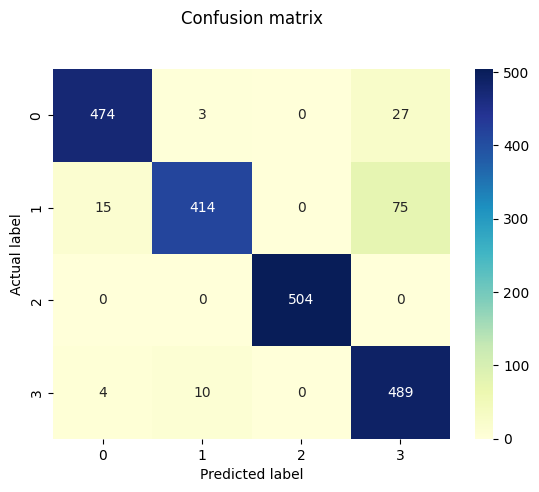

In [10]:
# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded y_test to class labels
y_test_classes = np.argmax(y_test, axis=1)

# Making the Confusion Matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
print(cm)

# Plot the confusion matrix
p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Classification report

In [11]:
#import classification_report
print(classification_report(y_test_classes,y_pred_classes))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       504
           1       0.97      0.82      0.89       504
           2       1.00      1.00      1.00       504
           3       0.83      0.97      0.89       503

    accuracy                           0.93      2015
   macro avg       0.94      0.93      0.93      2015
weighted avg       0.94      0.93      0.93      2015



63/63 [==============================] - 0s 653us/step


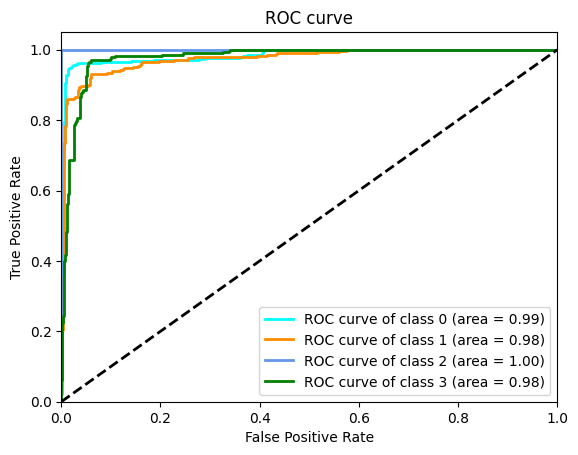

In [12]:
# Assuming your model is 'classifier' and already trained
y_pred_proba = model.predict(X_test)

# Compute ROC curve and ROC area for each class
n_classes = y_test.shape[1]  # Assuming y_test is one-hot encoded
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC Curve
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# Testing on validation data (data the model has never seen before)

90/90 [==============================] - 0s 579us/step
[[689   7   0  23]
 [ 25 591   0 104]
 [  0   0 718   2]
 [ 11  14   0 694]]
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       719
           1       0.97      0.82      0.89       720
           2       1.00      1.00      1.00       720
           3       0.84      0.97      0.90       719

    accuracy                           0.94      2878
   macro avg       0.94      0.94      0.94      2878
weighted avg       0.94      0.94      0.94      2878



Text(0.5, 23.52222222222222, 'Predicted label')

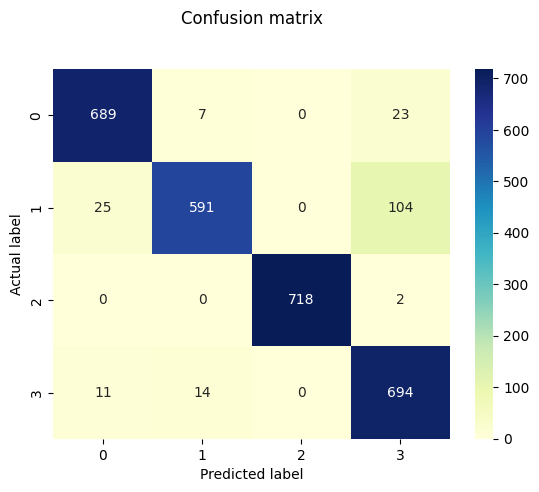

In [13]:
y_val_pred = model.predict(X_val)

# Convert probabilities to class labels
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Convert one-hot encoded y_test to class labels
y_val_classes = np.argmax(y_val, axis=1)

# Making the Confusion Matrix
cm = confusion_matrix(y_val_classes, y_val_pred_classes)
print(cm)

#import classification_report
print(classification_report(y_val_classes,y_val_pred_classes))

# Plot the confusion matrix
p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

This is proof that the model is accurate. data needs to be clean when sent to the robot

# Testing with actual never seen before data

In [55]:
# Predicting the Test set results
test_df_B = pd.read_csv("test/test_B.csv")
test_df_F = pd.read_csv("test/test_F.csv")
test_df_L = pd.read_csv("test/test_L.csv")
test_df_R = pd.read_csv("test/test_R.csv")

test_df_B.drop(['Sample Count'],axis=1,inplace=True)
test_df_F.drop(['Sample Count'],axis=1,inplace=True)
test_df_L.drop(['Sample Count'],axis=1,inplace=True)
test_df_R.drop(['Sample Count'],axis=1,inplace=True)

# test_df_B = pd.read_csv("backward_final_labelled.csv")
# test_df_F = pd.read_csv("forward_final_labelled.csv")
# test_df_L = pd.read_csv("left_final_labelled.csv")
# test_df_R = pd.read_csv("right_final_labelled.csv")

# test_df_B.drop(['Sample Count','Movement'],axis=1,inplace=True)
# test_df_F.drop(['Sample Count','Movement'],axis=1,inplace=True)
# test_df_L.drop(['Sample Count','Movement'],axis=1,inplace=True)
# test_df_R.drop(['Sample Count','Movement'],axis=1,inplace=True)

In [56]:
features = ['Mean', 'Skewness', 'Kurtosis', 'Relative Theta Power', 'Relative Alpha Power', 'Relative Beta Power',
                    'Relative Gamma Power', 'Relative Mu Power', 'Entropy', 'Complexity', 'Bispectrum Relative Theta Power',
                    'Bispectrum Relative Alpha Power', 'Bispectrum Relative Beta Power', 'Bispectrum Relative Gamma Power', 'Third Moment']

# Means and standard deviations calculated from training data
feature_means = [
    0.008766941128661169,
    -0.5163828963053286,
    18.789033940372978,
    0.0033610710025781297,
    0.008430050297967282,
    0.23371823861148722,
    0.26764958117377546,
    0.005923435315469626,
    1.6774030595225673,
    813.7751673828361,
    0.0024626561302796726,
    0.005634546851066067,
    0.2785159317877636,
    0.22742071460022975,
    -567742.9624711577
]

feature_std_devs = [
    0.9881721809825954,
    2.1847848489774786,
    20.96172885650971,
    0.013137574838904558,
    0.020360254299991994,
    0.0844387963098916,
    0.094688416889555,
    0.01647607558470322,
    0.8712593693717688,
    1413.2070778075251,
    0.012542240365146643,
    0.025527120812980416,
    0.12871067849253046,
    0.13776269630725865,
    4107060.5629486465
]

# Create DataFrames
feature_means_df = pd.DataFrame([feature_means], columns=features)
feature_std_devs_df = pd.DataFrame([feature_std_devs], columns=features)

In [57]:
test_df_B = test_df_B[features]
test_df_F = test_df_F[features]
test_df_L = test_df_L[features]
test_df_R = test_df_R[features]

# test_df_B

In [28]:
# feature_means_df

,Mean,Skewness,Kurtosis,Relative Theta Power,Relative Alpha Power,Relative Beta Power,Relative Gamma Power,Relative Mu Power,Entropy,Complexity,Bispectrum Relative Theta Power,Bispectrum Relative Alpha Power,Bispectrum Relative Beta Power,Bispectrum Relative Gamma Power,Third Moment
0,0.008767,-0.516383,18.789034,0.003361,0.00843,0.233718,0.26765,0.005923,1.677403,813.775167,0.002463,0.005635,0.278516,0.227421,-567742.962471


In [29]:
# feature_std_devs_df

,Mean,Skewness,Kurtosis,Relative Theta Power,Relative Alpha Power,Relative Beta Power,Relative Gamma Power,Relative Mu Power,Entropy,Complexity,Bispectrum Relative Theta Power,Bispectrum Relative Alpha Power,Bispectrum Relative Beta Power,Bispectrum Relative Gamma Power,Third Moment
0,0.988172,2.184785,20.961729,0.013138,0.02036,0.084439,0.094688,0.016476,0.871259,1413.207078,0.012542,0.025527,0.128711,0.137763,4.107061e+06


In [58]:
standardized_df_B = (test_df_B - feature_means_df.iloc[0]) / feature_std_devs_df.iloc[0]
standardized_df_F = (test_df_F - feature_means_df.iloc[0]) / feature_std_devs_df.iloc[0]
standardized_df_L = (test_df_L - feature_means_df.iloc[0]) / feature_std_devs_df.iloc[0]
standardized_df_R = (test_df_R - feature_means_df.iloc[0]) / feature_std_devs_df.iloc[0]

# standardized_df_B

In [59]:
testF = model.predict(standardized_df_F)
testB = model.predict(standardized_df_B)
testL = model.predict(standardized_df_L)
testR = model.predict(standardized_df_R)

testF_classes = np.argmax(testF, axis=1)
zeros_array = np.full(len(testF_classes), 0)
testB_classes = np.argmax(testB, axis=1)
ones_array = np.full(len(testB_classes), 1)
testL_classes = np.argmax(testL, axis=1)
twos_array = np.full(len(testL_classes), 2)
testR_classes = np.argmax(testR, axis=1)
threes_array = np.full(len(testR_classes), 3)

full_test_pred = np.concatenate((testF_classes,testB_classes,testL_classes,testR_classes))
full_test_actual = np.concatenate((zeros_array,ones_array,twos_array,threes_array))

1/1 [==============================] - 0s 11ms/step


[[ 0  1  0 13]
 [ 0  0 14  0]
 [ 0  6  0  8]
 [ 0  8  0  6]]


Text(0.5, 23.52222222222222, 'Predicted label')

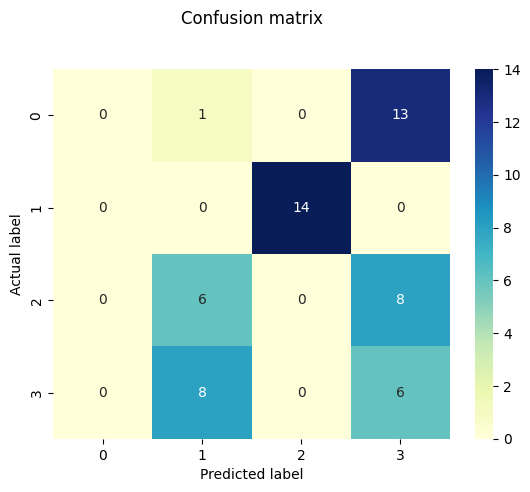

In [60]:
# Making the Confusion Matrix
cm = confusion_matrix(full_test_actual, full_test_pred)
print(cm)

# Plot the confusion matrix
p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [61]:
#import classification_report
print(classification_report(full_test_actual,full_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.00      0.00      0.00        14
           2       0.00      0.00      0.00        14
           3       0.22      0.43      0.29        14

    accuracy                           0.11        56
   macro avg       0.06      0.11      0.07        56
weighted avg       0.06      0.11      0.07        56



c:\Users\logoz\OneDrive\Desktop\machine learning WIP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\logoz\OneDrive\Desktop\machine learning WIP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\logoz\OneDrive\Desktop\machine learning WIP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

# Storing model to deploy

In [23]:
# # Save tensorflow model
# save_model(model=model, filepath='tensorflow', save_format='tf')

INFO:tensorflow:Assets written to: tensorflow\assets


INFO:tensorflow:Assets written to: tensorflow\assets


In [24]:
# # Convert to tensorflow lite model
# import tensorflow as tf

# # Load your saved model
# saved_model_dir = 'tensorflow'

# # Convert the model to TensorFlow Lite format
# converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
# tflite_model = converter.convert()

# # Save the converted model
# with open('tflite/model.tflite', 'wb') as f:
#     f.write(tflite_model)

In [22]:
# import tensorflow as tf

# imported = tf.saved_model.load("tensorflow")
# f = imported.signatures["serving_default"]

# # Create a dummy input tensor with the correct shape (e.g., batch size of 1 and 22 features)
# # row = df.iloc[0].drop('Movement')
# # input_row = row.to_numpy()[np.newaxis, :]
# input_row = X_val[0][np.newaxis, :]

# # Pass the input tensor with the correct argument name
# output = f(dense_input=tf.constant(input_row, dtype=tf.float32))

# output_tensor = output['dense_4']
# probabilities = output_tensor.numpy()[0]

# # Extract the individual probabilities
# prob_forward = probabilities[0]
# prob_backward = probabilities[1]
# prob_left = probabilities[2]
# prob_right = probabilities[3]

# print("Probability Forward:", prob_forward)
# print("Probability Backward:", prob_backward)
# print("Probability Left:", prob_left)
# print("Probability Right:", prob_right)
